In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

#On Mac you may encounter an error related to OMP, this is a workaround, but slows down the code
os.environ['KMP_DUPLICATE_LIB_OK']='True' #https://github.com/dmlc/xgboost/issues/1715

In [3]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.8.0'

In [4]:
from openbot import dataloader, data_augmentation, utils, train

## Set train and test dirs

Define the dataset directory and give it a name. Inside the dataset folder, there should be two folders, `train_data` and `test_data`. 

In [5]:
dataset_dir = "dataset"
train_data_dir = os.path.join(dataset_dir, "train_data")
test_data_dir = os.path.join(dataset_dir, "test_data")

## Download session

In [6]:
#session_id = "AKfbgaWN92Tn7hitOtTm"

In [7]:
#!python download_full_recordings.py -i {session_id}

## Prepare dataset

In [8]:
#!python prepare_dataset.py -i download/{session_id} -o {dataset_dir}/uploaded

In [9]:
all_data = []
for folder in os.listdir(f"{dataset_dir}/uploaded"):
    folder_path = f"{dataset_dir}/uploaded/{folder}"
    if os.path.isdir(folder_path):
        all_data.append(folder_path)
        
print(f"All Data:\n {all_data}")

All Data:
 []


In [10]:
train_data = all_data[:-1]
test_data = all_data[-1:]

print(f"Train Data:\n {train_data}")
print(f"Test Data:\n {test_data}")

Train Data:
 []
Test Data:
 []


In [11]:
for folder in train_data:
    !mv {folder} {train_data_dir}
    
for folder in test_data:
    !mv {folder} {test_data_dir}

## Hyperparameters

You may have to tune the learning rate and batch size depending on your available compute resources and dataset. As a general rule of thumb, if you increase the batch size by a factor of n, you can increase the learning rate by a factor of sqrt(n). In order to accelerate training and make it more smooth, you should increase the batch size as much as possible. In our paper we used a batch size of 128. For debugging and hyperparamter tuning, you can set the number of epochs to a small value like 10. If you want to train a model which will achieve good performance, you should set it to 50 or more. In our paper we used 100.

In [12]:
params = train.Hyperparameters()

params.MODEL = "pilot_net"
params.TRAIN_BATCH_SIZE = 64
params.TEST_BATCH_SIZE = 16
params.LEARNING_RATE = 0.0001
params.NUM_EPOCHS = 100
params.BATCH_NORM = True
params.IS_CROP = True
params.USE_LAST = False

## Pre-process the dataset

In [13]:
tr = train.Training(params)
tr.train_data_dir = train_data_dir
tr.test_data_dir = test_data_dir
tr.dataset_name = "TestSession_1"

Running this for the first time will take some time. This code will match image frames to the controls (labels) and indicator signals (commands).  By default, data samples where the vehicle was stationary will be removed. If this is not desired, you need to pass `remove_zeros=False`. If you have made any changes to the sensor files, changed `remove_zeros` or moved your dataset to a new directory, you need to pass `redo_matching=True`. 

In [14]:
%%capture
train.process_data(tr, redo_matching=True, remove_zeros=True)

In [15]:
import threading
def broadcast(event, payload=None):
    print(event, payload)
event = threading.Event()
my_callback = train.MyCallback(broadcast, event)

In the next step, you can convert your dataset to a tfrecord, a data format optimized for training. You can skip this step if you already created a tfrecord before or if you want to train using the files directly. 

In [16]:
#%%capture
#train.create_tfrecord(my_callback)

## Load the dataset

If you did not create a tfrecord and want to load and buffer files from disk directly, set `no_tf_record = True`.

In [17]:
no_tf_record = True

In [18]:
if no_tf_record:
    tr.train_data_dir = train_data_dir
    tr.test_data_dir = test_data_dir
    train.load_data(tr, verbose=0)
else:
    tr.train_data_dir = os.path.join(dataset_dir, "tfrecords/train.tfrec")
    tr.test_data_dir = os.path.join(dataset_dir, "tfrecords/test.tfrec")
    train.load_tfrecord(tr, verbose=0)

Number of train samples: 25089
Number of test samples: 996


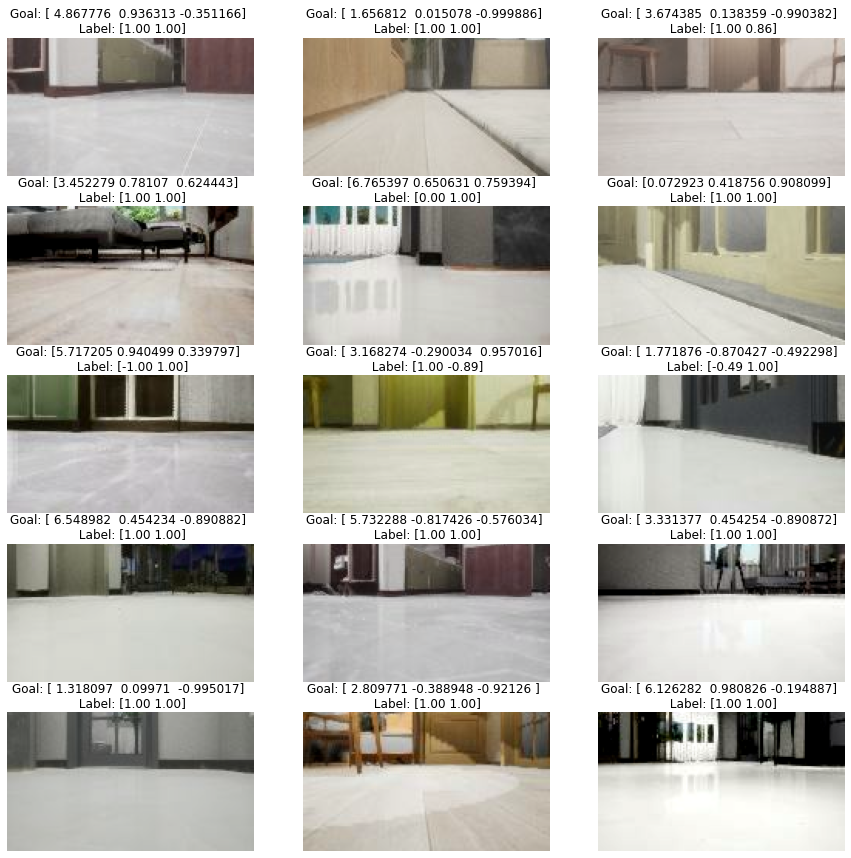

In [19]:
(image_batch, cmd_batch), label_batch = next(iter(tr.train_ds))
utils.show_train_batch(image_batch.numpy(), cmd_batch.numpy(), label_batch.numpy())

## Training

In [20]:
train.do_training(tr, my_callback, verbose=1)

TestSession_1_pilot_net_lr0.0001_bz64_bn
Model: "pilot_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 90, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 43, 78, 24)   1824        ['img_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 43, 78, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                 

## Evaluation

The loss and mean absolute error should decrease. This indicates that the model is fitting the data well. The custom metrics (direction and angle) should go towards 1. These provide some additional insight to the training progress. The direction metric measures weather or not predictions are in the same direction as the labels. Similarly the angle metric measures if the prediction is within a small angle of the labels. The intuition is that driving in the right direction with the correct steering angle is most critical part for good final performance.

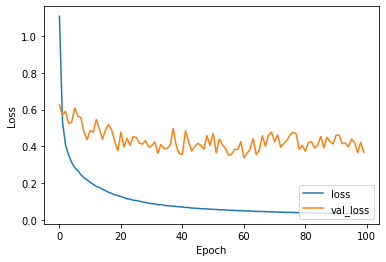

In [21]:
plt.plot(tr.history.history['loss'], label='loss')
plt.plot(tr.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig(os.path.join(tr.log_path,'loss.png'))

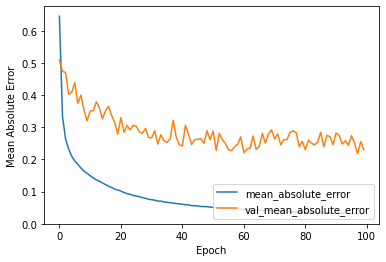

In [22]:
plt.plot(tr.history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(tr.history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='lower right')
plt.savefig(os.path.join(tr.log_path,'error.png'))

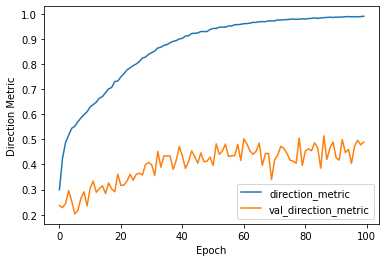

In [23]:
plt.plot(tr.history.history['direction_metric'], label='direction_metric')
plt.plot(tr.history.history['val_direction_metric'], label = 'val_direction_metric')
plt.xlabel('Epoch')
plt.ylabel('Direction Metric')
plt.legend(loc='lower right')
plt.savefig(os.path.join(tr.log_path,'direction.png'))

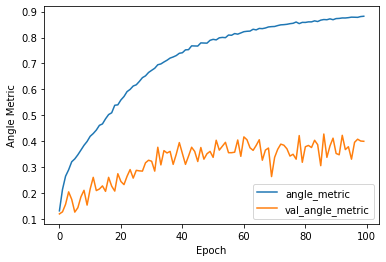

In [24]:
plt.plot(tr.history.history['angle_metric'], label='angle_metric')
plt.plot(tr.history.history['val_angle_metric'], label = 'val_angle_metric')
plt.xlabel('Epoch')
plt.ylabel('Angle Metric')
plt.legend(loc='lower right')
plt.savefig(os.path.join(tr.log_path,'angle.png'))

### Save tf lite models for best train and val checkpoint

In [25]:
best_train_index = np.argmin(np.array(tr.history.history['loss']))
best_train_checkpoint = "cp-best-train.ckpt"
best_train_tflite = utils.generate_tflite(tr.checkpoint_path, best_train_checkpoint)
utils.save_tflite (best_train_tflite, tr.checkpoint_path, "best-train")
print("Best Train Checkpoint (angle: %s, val_angle: %s, direction: %s, val_direction: %s, epoch: %s" \
      %(tr.history.history['angle_metric'][best_train_index], \
        tr.history.history['val_angle_metric'][best_train_index], \
        tr.history.history['direction_metric'][best_train_index], \
        tr.history.history['val_direction_metric'][best_train_index], \
        best_train_index))

Best Train Checkpoint (angle: 0.8820769786834717, val_angle: 0.4000000059604645, direction: 0.9897423386573792, val_direction: 0.48899999260902405, epoch: 99


In [26]:
best_val_index = np.argmin(np.array(tr.history.history['val_loss']))
best_val_checkpoint = "cp-best-val.ckpt"
best_val_tflite = utils.generate_tflite(tr.checkpoint_path, best_val_checkpoint)
utils.save_tflite (best_val_tflite, tr.checkpoint_path, "best-val")
print("Best Val Checkpoint (angle: %s, val_angle: %s, direction: %s, val_direction: %s, epoch: %s" \
      %(tr.history.history['angle_metric'][best_val_index], \
        tr.history.history['val_angle_metric'][best_val_index], \
        tr.history.history['direction_metric'][best_val_index], \
        tr.history.history['val_direction_metric'][best_val_index], \
        best_val_index))

Best Val Checkpoint (angle: 0.822519063949585, val_angle: 0.4169999957084656, direction: 0.9602417349815369, val_direction: 0.5019999742507935, epoch: 60


### Evaluate the best model (train loss) on the training set

In [34]:
best_train_model = utils.load_model(os.path.join(tr.checkpoint_path,best_train_checkpoint),tr.loss_fn,tr.metric_list, tr.custom_objects)
loss, mae, direction, angle = best_train_model.evaluate(tr.train_ds, steps=tr.image_count_train/tr.hyperparameters.TRAIN_BATCH_SIZE, verbose=1)

392/392 [==============================] - 4s 10ms/step - loss: 0.0276 - mean_absolute_error: 0.0250 - direction_metric: 0.9920 - angle_metric: 0.8975


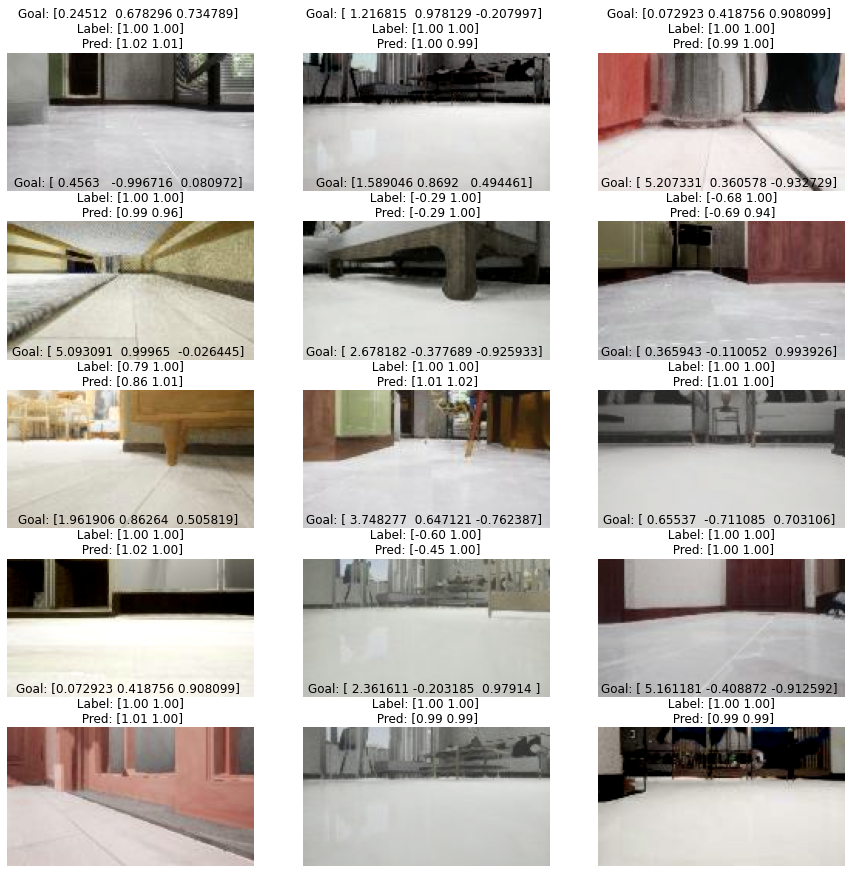

In [35]:
NUM_SAMPLES = 15
(image_batch, cmd_batch), label_batch = next(iter(tr.train_ds))
pred_batch = best_train_model.predict( (tf.slice(image_batch, [0, 0, 0, 0], [NUM_SAMPLES, -1, -1, -1]), tf.slice(cmd_batch, [0, 0], [NUM_SAMPLES, -1])) )
utils.show_test_batch(image_batch.numpy(), cmd_batch.numpy(), label_batch.numpy(), pred_batch)   

In [36]:
utils.compare_tf_tflite(best_train_model,best_train_tflite)

tflite: [[0.9154134  0.87563574]]
tf: [[0.9196031 0.8807025]]
Almost equal (5% tolerance): True


### Evaluate the best model (val loss) on the validation set

In [37]:
best_val_model = utils.load_model(os.path.join(tr.checkpoint_path,best_val_checkpoint),tr.loss_fn,tr.metric_list, tr.custom_objects)
loss, mae, direction, angle = best_val_model.evaluate(tr.test_ds, steps=tr.image_count_test/tr.hyperparameters.TEST_BATCH_SIZE, verbose=1)

62/62 [==============================] - 1s 6ms/step - loss: 0.3459 - mean_absolute_error: 0.2205 - direction_metric: 0.5020 - angle_metric: 0.4170


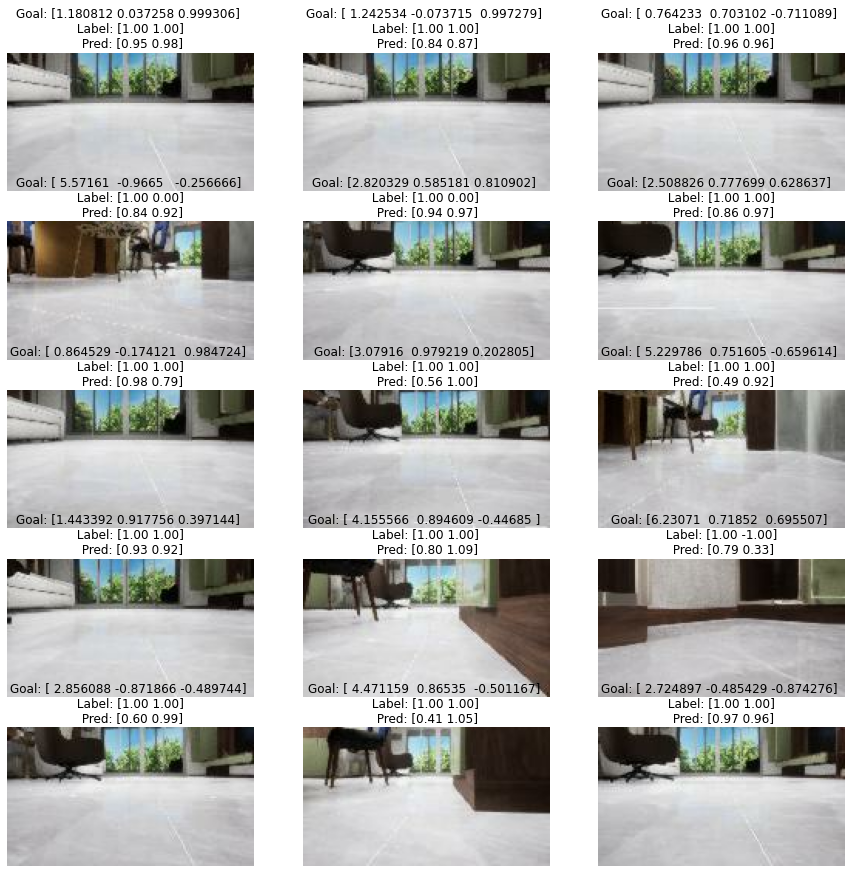

In [38]:
NUM_SAMPLES = 15
(image_batch, cmd_batch), label_batch = next(iter(tr.test_ds))
pred_batch = best_val_model.predict( (tf.slice(image_batch, [0, 0, 0, 0], [NUM_SAMPLES, -1, -1, -1]), tf.slice(cmd_batch, [0, 0], [NUM_SAMPLES, -1])) )
utils.show_test_batch(image_batch.numpy(), cmd_batch.numpy(), label_batch.numpy(), pred_batch)   

In [39]:
utils.compare_tf_tflite(best_val_model,best_val_tflite)

tflite: [[0.58209157 1.0214492 ]]
tf: [[0.59330124 1.0297359 ]]
Almost equal (5% tolerance): True


## Save the notebook as HTML

In [33]:
utils.save_notebook()
current_file = 'policy_learning.ipynb'
output_file = os.path.join(tr.log_path,'notebook.html')
utils.output_HTML(current_file, output_file)